## **Импорт и анализ данных.**

In [1]:
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import seaborn as sns
import gc, sys

In [2]:
gc.enable()

In [3]:
def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")


def memory_usage():
    memory_usage_by_variable = pd.DataFrame({k:sys.getsizeof(v) for (k,v) in globals().items()},index=['Size'])    
    memory_usage_by_variable = memory_usage_by_variable.T    
    memory_usage_by_variable = memory_usage_by_variable.sort_values(by='Size',ascending=False).head(10)   
    memory_usage_by_variable['Size'] = memory_usage_by_variable['Size'].apply(lambda x: obj_size_fmt(x))    
    return memory_usage_by_variable

Проверим данные на отсутствующие значения.

In [4]:
src_df = pd.read_csv('true_car_listings_prepeared.csv')

src_df.isna().sum()

Price           0
Year            0
Mileage    120943
City            0
State           0
Vin             0
Make            0
Model       77122
dtype: int64

Не очень хорошо, но не смертельно.

**Для начала нужно осмыслить данные, не затронутые порчей.**

Посмотрим на типы данных.

In [5]:
src_df.dtypes

Price        int64
Year         int64
Mileage    float64
City        object
State       object
Vin         object
Make        object
Model       object
dtype: object

In [6]:
src_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852122 entries, 0 to 852121
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Price    852122 non-null  int64  
 1   Year     852122 non-null  int64  
 2   Mileage  731179 non-null  float64
 3   City     852122 non-null  object 
 4   State    852122 non-null  object 
 5   Vin      852122 non-null  object 
 6   Make     852122 non-null  object 
 7   Model    775000 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 52.0+ MB


Памяти не много, так что оставлю как есть.

In [7]:
memory_usage()

,Size
src_df,290.51MB
_,1.60KB
_5,1.60KB
LabelEncoder,1.04KB
LinearRegression,1.04KB
Ridge,1.04KB
KFold,1.04KB
OneHotEncoder,1.04KB
KNeighborsClassifier,1.04KB
SGDRegressor,1.04KB


VIN точно никак ни на что не влияет, поскольку это изначально уникальный идентификатор. Удаляем.

In [8]:
print("Dataframe:\n\t-Columns:{}\n\t-Rows count:{}\n".format(src_df.columns, src_df.shape[0]))

Dataframe:
	-Columns:Index(['Price', 'Year', 'Mileage', 'City', 'State', 'Vin', 'Make', 'Model'], dtype='object')
	-Rows count:852122



In [9]:
src_df.drop(['Vin'], axis=1, inplace=True)
print("Dataframe:\n\t-Columns:{}\n\t-Rows count:{}\n".format(src_df.columns, src_df.shape[0]))

Dataframe:
	-Columns:Index(['Price', 'Year', 'Mileage', 'City', 'State', 'Make', 'Model'], dtype='object')
	-Rows count:852122



Посмотрим на диапазоны цены и пробега.

In [10]:
print("Range of prices is:\t{}".format(src_df.Price.max() - src_df.Price.min()))
print("Range of mileage is:\t{}".format(src_df.Mileage.max() - src_df.Mileage.min()))

Range of prices is:	499500
Range of mileage is:	2856191.0


Многовато. Натуральный логорифм нам в помощь.<br>
Но есть нюанс - нулевые значения. Посмотрим есть ли они и сколько.

In [11]:
src_df.isin([0]).sum()

Price      53308
Year           0
Mileage        0
City           0
State          0
Make           0
Model          0
dtype: int64

Нда. В этом датасете хоть что-то в порядке?<br>
Получается, автомобили с нулевой ценой это что? Заберите даром? Ну такое, в принципе, возможно. Но только для очень старых или битых автомобилей. 

In [12]:
print(src_df['Year'].max())

2018


In [13]:
wrong_price_mask = (src_df['Year'] > (2000)) & (src_df['Price'] == 0)
src_df.loc[wrong_price_mask]

,Price,Year,Mileage,City,State,Make,Model
4,0,2016,NaN,Lindon,UT,Acura,ILXAutomatic
49,0,2014,16848.0,Clearwater,FL,Acura,ILX5-Speed
74,0,2014,21064.0,Stanton,CA,Acura,TSX5-Speed
79,0,2015,18583.0,Montclair,CA,Acura,ILX5-Speed
91,0,2012,81301.0,Homestead,FL,Acura,NaN
...,...,...,...,...,...,...,...
852015,0,2016,43699.0,Odessa,TX,Volvo,XC90AWD
852044,0,2016,14942.0,Clive,IA,Volvo,XC90AWD
852060,0,2016,18435.0,Oak Park,IL,Volvo,XC90AWD
852095,0,2017,3335.0,Concord,NH,Volvo,V90


Поскольку у нас нет никаких данных о состоянии автомобиля, предположу, что это ошибка ввода. Именно эти значения мне и нужно будет предсказать в итоге.

In [14]:
print("Original:\n-----\n{}\n".format(src_df['Price'].sample(n=5, random_state=42)))

#src_df['Price'] = src_df.apply(lambda x: np.log(x.Price) if x.Price != 0 else 0, axis=1)

print("Ln applyed:\n-----\n{}\n".format(src_df['Price'].sample(n=5, random_state=42)))

Original:
-----
729827    17300
825968    12615
353439    22995
477184    53692
282908    20900
Name: Price, dtype: int64

Ln applyed:
-----
729827    17300
825968    12615
353439    22995
477184    53692
282908    20900
Name: Price, dtype: int64



In [15]:
src_df.isin([0]).sum()

Price      53308
Year           0
Mileage        0
City           0
State          0
Make           0
Model          0
dtype: int64

Как видно, нулевые значения не стали np.inf.

In [16]:
print("Original:\n-----\n{}\n".format(src_df['Mileage'].sample(n=5, random_state=42)))
# src_df['Mileage'] = src_df['Mileage'].apply(np.log)
print("Ln applyed:\n-----\n{}\n".format(src_df['Mileage'].sample(n=5, random_state=42)))

Original:
-----
729827    53490.0
825968    41451.0
353439    32655.0
477184        NaN
282908    34284.0
Name: Mileage, dtype: float64

Ln applyed:
-----
729827    53490.0
825968    41451.0
353439    32655.0
477184        NaN
282908    34284.0
Name: Mileage, dtype: float64



Год производства. Сам по себе этот параметр мало что значит. Попробую переделать его в возраст (Age). <br>
1 if Age <= 5<br>
2 if 5 < Age <= 10<br>
3 if 10 < Age <= 20<br>
4 if 20 < Age<br>

И тут произошло интересное. Я год из числового значения перевёл в категориальное.

**Категориальные данные.**

Тут всё не слишком сложно. Есть две основные методики оформить категориальные данные. Подстановка числового (выбранного по разным алгоритмам) значения или унитарный код (Hash, по сути, вариант унитарного кода). <br>
Просто взглянув на унитарный код становится понятно, что придется добавить много предикторов и всё станет не очень наглядно. Но есть один нюанс. Если просто подставить числа, то как понять, что модель автомобиля с числом 1 равнозначна модели с числом 2300? Да вобщем никак.<br>
Унитарный же код, если вспомнить уравнение линейной регрессии, позволяет моментально выкинуть (за счет нулевых значений предикторов) целый пласт значений из расчета. Тем самым, по идее, должна вырости точность модели. Посмотрим. 

Добавлю новые столбцы - Age_0_5, Age_6_10, Age_11_20, Age_20_. 

In [17]:
max_year = src_df['Year'].max()

age_0_5 = list()
age_6_10 = list()
age_11_20 = list()
age_20_ = list()

for year in src_df['Year']:
    age = max_year - year
    if age <= 5:
        age_0_5.append(1)
        age_6_10.append(0)
        age_11_20.append(0)
        age_20_.append(0)
    elif age > 5 and age <=10:
        age_0_5.append(0)
        age_6_10.append(1)
        age_11_20.append(0)
        age_20_.append(0)
    elif age > 10 and age <=20:
        age_0_5.append(0)
        age_6_10.append(0)
        age_11_20.append(1)
        age_20_.append(0)
    elif age > 20:
        age_0_5.append(0)
        age_6_10.append(0)
        age_11_20.append(0)
        age_20_.append(1)
    else:
        age_0_5.append(0)
        age_6_10.append(0)
        age_11_20.append(0)
        age_20_.append(0)

src_df['Age_0_5'] = age_0_5
src_df['Age_6_10'] = age_6_10
src_df['Age_11_20'] = age_11_20
src_df['Age_20_'] = age_20_

In [18]:
print("-----\n{}\n".format(src_df.sample(n=5)))

-----
        Price  Year   Mileage          City State       Make     Model  \
794484   6900  2007  104042.0  Merrillville    IN     Toyota       NaN   
76030   22999  2016   38732.0       Orlando    FL   Cadillac    XTSFWD   
371948  37448  2015   58010.0       McAllen    TX        GMC  Yukon2WD   
365068  37400  2017   13170.0  Broken Arrow    OK        GMC    Acadia   
106650  17977  2017       NaN        Sumter    SC  Chevrolet   TraxFWD   

        Age_0_5  Age_6_10  Age_11_20  Age_20_  
794484        0         0          1        0  
76030         1         0          0        0  
371948        1         0          0        0  
365068        1         0          0        0  
106650        1         0          0        0  



Попробую посмотреть корреляции.

<AxesSubplot:>

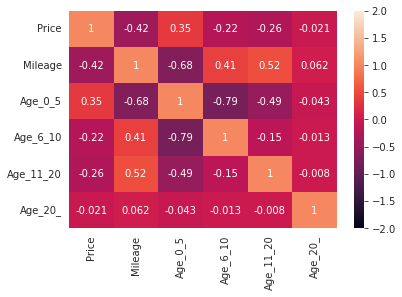

In [19]:
src_df.drop(['Year'], axis=1, inplace=True)

sns.set_style(style='white')
sns.set_palette(sns.color_palette("BrBG"))

numeric_df = src_df.select_dtypes(include=['float64', 'int64'])
numeric_df = numeric_df.loc[(src_df['Price'] != 0) & (src_df['Mileage'] != np.NaN) & (src_df['Model'] != np.NaN)]

sns.heatmap(numeric_df.corr(), annot=True, vmin=-2, vmax=2)

Ну, ничего катастрофического я тут не вижу.

Попробую то же самое сделать с моделью и штатом. А вот город, пожалуй вобще исключу из исследования. Я не вижу, каким образом город может влиять на цену.

In [20]:
src_df.drop(['City'], axis=1, inplace=True)

In [21]:
states_one_hot = pd.get_dummies(src_df['State'], prefix="state")

src_df.drop(['State'], axis=1, inplace=True)

src_df = src_df.join(states_one_hot)

In [22]:
models_one_hot = pd.get_dummies(src_df['Model'], prefix="model")

src_df = src_df.join(models_one_hot)

In [23]:
makes_one_hot = pd.get_dummies(src_df['Make'], prefix="make")

src_df.drop(['Make'], axis=1, inplace=True)

src_df = src_df.join(makes_one_hot)

In [24]:
src_df.shape

(852122, 2818)

Количество столбцов настораживает.

In [25]:
src_df.isna().sum()

Price                   0
Mileage            120943
Model               77122
Age_0_5                 0
Age_6_10                0
                    ...  
make_Tesla              0
make_Toyota             0
make_Volkswagen         0
make_Volvo              0
make_smart              0
Length: 2818, dtype: int64

In [26]:
src_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852122 entries, 0 to 852121
Columns: 2818 entries, Price to make_smart
dtypes: float64(1), int64(5), object(1), uint8(2811)
memory usage: 2.3+ GB


Немного (ну совсем чуть-чуть) выросло потребление памяти... В 40 раз...

In [27]:
memory_usage()

,Size
src_df,2.43GB
models_one_hot,2.24GB
states_one_hot,49.10MB
makes_one_hot,48.26MB
numeric_df,43.69MB
_13,14.66MB
age_11_20,6.71MB
age_20_,6.71MB
age_6_10,6.71MB
age_0_5,6.71MB


## **Импутация данных.**

И вот тольо теперь я могу попробовать импутировать недостающие данные...

Для начала нужно понять, пересекаются порченные данные или нет.

In [28]:
corrupted_mileage = src_df.loc[src_df['Mileage'].isna()]

print(corrupted_mileage.shape)
print(corrupted_mileage['Model'].isna().sum())
print(corrupted_mileage['Price'].isin([0]).sum())
#corrupted_mileage.head

(120943, 2818)
10909
7634


In [29]:
corrupted_mileage = corrupted_mileage.loc[(src_df['Price'] != 0) & (~src_df['Model'].isna())]
print(corrupted_mileage.shape)

(103067, 2818)


Плохо, но не смертельно. Возможно эти 17 тысяч записей придется выкинуть.

Попробую применить KNN для нахождения пробега. Предикторами будут штат, модель, производитель, возраст и цена.

In [30]:
clear_df = src_df.loc[(src_df['Price'] != 0) & (~src_df['Mileage'].isna()) & (~src_df['Model'].isna())]
print(clear_df.shape)
print(clear_df['Price'].isin([0]).sum())
print(clear_df['Model'].isna().sum())
print(clear_df['Mileage'].isna().sum())

(623472, 2818)
0
0
0


In [31]:
X = clear_df.filter(regex='^Age_',axis=1)
X = X.join(clear_df.filter(regex='^state_',axis=1))
X = X.join(clear_df.filter(regex='^model_',axis=1))
X = X.join(clear_df.filter(regex='^make_',axis=1))
X = X.join(clear_df.Price)

y = pd.DataFrame(clear_df['Mileage'])

clear_df.to_pickle('clear_df.bak')
src_df.to_pickle('src_df.bak')

del age_0_5
del age_6_10
del age_11_20
del age_20_
del numeric_df
del states_one_hot
del models_one_hot
del makes_one_hot
del clear_df
del src_df
del wrong_price_mask

gc.collect()
memory_usage()

,Size
X,1.76GB
corrupted_mileage,295.14MB
y,26.25MB
_13,14.66MB
__,284.29KB
_25,284.29KB
_5,1.60KB
_27,1.28KB
_,1.28KB
_7,1.28KB


# **И тут я понял, что в ML памяти много не бывает!**

In [ ]:
X['Price'] = X['Price'].astype(np.int64)
y = y.astype(np.int64)

#print(X.head)
#print(y.head)

X_ = X.sample(frac=0.3, random_state=42)
y_ = y.sample(frac=0.3, random_state=42)


best_r_model = LinearRegression()
best_r_score = 0.0
best_knn_model = KNeighborsClassifier()
best_knn_score = 0.0

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
k_fold.get_n_splits(X_)

for train_index, test_index in k_fold.split(X_):
    X_train = X_.iloc[train_index]
    X_test = X_.iloc[test_index]
    y_train = y_.iloc[train_index]
    y_test = y_.iloc[test_index]
    
    r_model = LinearRegression()
    r_model.fit(X_train, y_train)
    preds = r_model.predict(X_test)
    
    r2 = r2_score(y_test, preds)
    if r2 > best_r_score:
        best_r_model = r_model
        best_r_score = r2
        print("Best R2 score for LinearRegression at the moment is:\t{}.".format(r2))
    else:
        print("Current R2 score for LinearRegression at the moment is:\t{}.".format(r2))
        
    knn_model = KNeighborsClassifier(n_neighbors=3)
    knn_model.fit(X_train, y_train.values.ravel())
    knn_preds = knn_model.predict(X_test)
    
    r2 = r2_score(y_test, knn_preds)
    if r2 > best_knn_score:
        best_knn_model = knn_model
        best_knn_score = r2
        print("Best R2 score for KNN at the moment is:\t{}.".format(r2))
    else:
        print("Current R2 score for KNN at the moment is:\t{}.".format(r2))

        
print ("KFold done.")


#model.fit(X_train, y_train)        
#print(y.head)

Current R2 score for LinearRegression at the moment is:	-1945699883.7718973.
Best R2 score for KNN at the moment is:	0.21012902904919262.
Current R2 score for LinearRegression at the moment is:	-2106.0649771783037.


In [ ]:
#preds = model.predict(X_test)

#print("R^2: ", r2_score(y_test, preds))

Лучше, чем наугад, но плохо...

Попробую методом тыка. Научного, само собой!!!

In [ ]:
#X_ = X.sample(frac=0.25, random_state=42)
#y_ = y.sample(frac=0.25, random_state=42)


#X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.75)

classifiers = [
    #svm.SVR()
    #linear_model.Ridge(),
    #linear_model.Lasso(),
    #linear_model.SGDRegressor(),
    #linear_model.BayesianRidge(),
    #linear_model.LassoLars(),
    #linear_model.ARDRegression(),
    #linear_model.PassiveAggressiveRegressor(),
    #linear_model.TheilSenRegressor(),
    #linear_model.LinearRegression()
]

for item in classifiers:
    model = item
    model.fit(X_train, y_train)#.values.ravel()) 
    preds = model.predict(X_test)
    print("R2 score for {} is:\t{}.".format(item, r2_score(y_test, preds)))

0.6410646403641409 - price year no cat<br>
0.577232476900628 - price year_cat<br>
0.6640694949285478 - price year make_cat<br>
0.6909865280529583 - price year make_cat model_cat<br>
0.6917988655789165 - price year make_cat model_cat state_cat<br>
0.6914529038815127 - price year make_cat model_cat state_cat city<br>
0.6901096137806162 - price year make_oh model_cat<br>

